In [1]:
# IMPORTING REQUIRED LIBRARIES AND SETTING UP EVERYTHING
!pip install geopandas
from osgeo import ogr
import pandas as pd
import numpy as np
import seaborn as sns
import os
import geopandas as gpd
import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.feature_selection import SelectKBest, chi2
from scipy.stats import chi2_contingency
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

from google.colab import drive
drive.mount('/content/drive')

import gspread
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

pd.set_option('display.max_rows', 999)

Mounted at /content/drive


For Geo-Spatial Analysis, I have compared Air Quality in Patna and Delhi, pre-Covid lockdown and during lockdown, along with some other factors which could have had an influence during this period. 
Note : AQI is an indicator of the quality of air in the atmosphere. Higher the AQI, lower is the quality of air and more complications can be caused in the form of breathing discomfort, heart diseases, etc.


I will start with reading Air-quality data and making it analysis ready. 
The AQI data was taken from the following source : https://www.kaggle.com/rohanrao/air-quality-data-in-india/version/12
---



In [2]:
# Setting up default system paths
path = '/content/drive/MyDrive/'
geo_path = path+'IND_adm/'
os.chdir(path)

In [3]:
# defining a function to fill NA values through interpolation
def fill_values(df,col_list,method,type_dict):
  for col in col_list:
    df[col].replace('',np.nan,inplace=True)
    df[col].interpolate(method=method,inplace=True)
    df[col].fillna(0,inplace=True)
    df[col] = df[col].astype(type_dict[col])
  return df

In [4]:
# Reading data
worksheet = gc.open('city_day.csv').sheet1
rows = worksheet.get_all_values()
df = pd.DataFrame.from_records(rows)
df.columns = df.loc[0].tolist()
df.drop(index=0,inplace=True)
df.reset_index(drop=True,inplace=True)
# df = pd.read_csv('city_day.csv')

In [5]:
# Processing data initially
col_list = ['AQI','NO2','CO','SO2','Benzene','NH3']
type_dict = {'NO2':float,'CO':float,'AQI':int,'SO2':float,'Benzene':float,'NH3':float}
df = fill_values(df,col_list,'ffill',type_dict)

df['Date'] =  pd.to_datetime(df['Date'])
df['Date_year'] = pd.DatetimeIndex(df['Date']).year
df['Date_month'] = pd.DatetimeIndex(df['Date']).month
df['Month'] = df['Date'].apply(lambda x : x.strftime('%Y-%m'))
df['Week'] = df['Date'].dt.week

In [6]:
df.shape

(29531, 20)

In [ ]:
df['Date'].dt.year.unique()

array([2015, 2016, 2017, 2018, 2019, 2020])

In [ ]:
# Checking the lockdown and non-lockdown time periods
df[df['Date_year'].isin([2018,2020])].groupby(['Date_year','Date_month'])['Date'].count()

Date_year  Date_month
2018       1             527
           2             476
           3             527
           4             531
           5             558
           6             540
           7             558
           8             558
           9             540
           10            558
           11            540
           12            558
2020       1             733
           2             725
           3             796
           4             780
           5             806
           6             780
           7              26
Name: Date, dtype: int64

In [ ]:
df.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,Date_year,Date_month
0,Ahmedabad,2015-01-01,,,0.92,18.22,17.15,,0.92,27.64,133.36,0,0.02,0,,,2015,1
1,Ahmedabad,2015-01-02,,,0.97,15.69,16.46,,0.97,24.55,34.06,3.68,5.5,3.77,,,2015,1
2,Ahmedabad,2015-01-03,,,17.4,19.3,29.7,,17.4,29.07,30.7,6.8,16.4,2.25,,,2015,1
3,Ahmedabad,2015-01-04,,,1.7,18.48,17.97,,1.7,18.59,36.08,4.43,10.14,1,,,2015,1
4,Ahmedabad,2015-01-05,,,22.1,21.42,37.76,,22.1,39.33,39.31,7.01,18.89,2.78,,,2015,1


In [ ]:
# Filtering only the relevant data i.e. the months of March, April and May for pre-Covid lockdown (2018) and during lockdown (2020)
geo_df = df.query('(City == "Delhi" or City == "Patna") and (Date_year == 2018 or Date_year == 2020) and (Date_month >= 3 and Date_month <= 5)').reset_index().drop(columns = ['index'])
geo_df.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,Date_year,Date_month
0,Delhi,2018-03-01,120.71,256.86,45.93,51.74,79.9,49.29,1.43,14.9,40.69,2.3,5.76,0.56,293,Poor,2018,3
1,Delhi,2018-03-02,139.18,253.32,46.05,50.64,78.23,48.86,1.64,11.52,45.55,3.01,4.5,0.77,300,Poor,2018,3
2,Delhi,2018-03-03,98.25,205.92,26.84,41.07,59.03,44.26,1.18,12.93,38.38,1.85,3.67,0.57,244,Poor,2018,3
3,Delhi,2018-03-04,79.83,182.26,25.27,39.02,56.08,39.35,0.99,12.95,34.95,1.63,2.92,0.14,205,Poor,2018,3
4,Delhi,2018-03-05,76.96,164.74,24.87,39.58,56.62,38.32,0.99,12.7,40.45,1.39,2.92,0,180,Moderate,2018,3


In [ ]:
# Checking for missing values in the Air-Quality Index
geo_df['AQI'].isnull().sum()

0

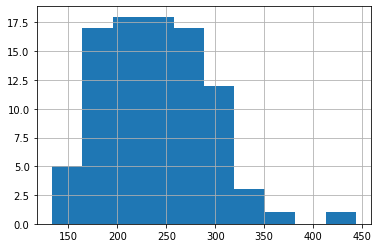

In [ ]:
geo_df[(geo_df['City']=='Delhi')&(geo_df['Date_year']==2018)]['AQI'].hist()

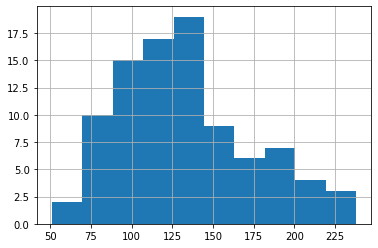

In [ ]:
geo_df[(geo_df['City']=='Delhi')&(geo_df['Date_year']==2020)]['AQI'].hist()

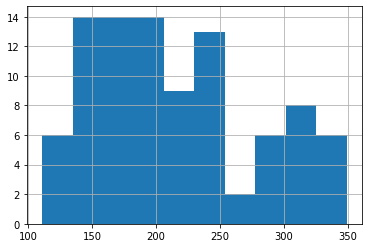

In [ ]:
geo_df[(geo_df['City']=='Patna')&(geo_df['Date_year']==2018)]['AQI'].hist()

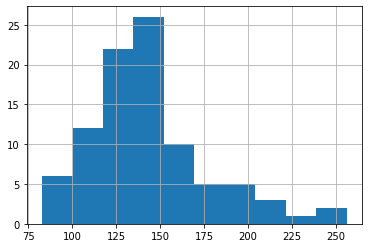

In [ ]:
geo_df[(geo_df['City']=='Patna')&(geo_df['Date_year']==2020)]['AQI'].hist()

Looking at the distributions across the lockdown and the non-lockdown months of the two cities, we can say that they are more or less normally distributed with little to no skew and thus, the mean can be a good measure of central tendency.

In [ ]:
# Getting the average AQI
geo_df['AQI'] = geo_df['AQI'].astype(int)
df2 = geo_df[['City','Date_year','AQI']].groupby(['City','Date_year'], as_index=False).mean()
df2

,City,Date_year,AQI
0,Delhi,2018,238.250000
1,Delhi,2020,132.706522
2,Patna,2018,214.750000
3,Patna,2020,142.826087


In [ ]:
# Storing these values for later use
delhi_2018 = round(float(df2.iloc[0]['AQI']), 2)
delhi_2020 = round(float(df2.iloc[1]['AQI']), 2)
patna_2018 = round(float(df2.iloc[2]['AQI']), 2)
patna_2020 = round(float(df2.iloc[3]['AQI']), 2)

In [ ]:
print (delhi_2018,
        delhi_2020,
        patna_2018,
        patna_2020)

238.25 132.71 214.75 142.83


After this, we need to work on Geo-spatial data and get it ready for analysis. I will be using a mix of GDAL and Geopandas to achieve the same.
This data was obtained from : https://www.diva-gis.org/gdata

In [ ]:
# Opening shapefile
source = ogr.Open(geo_path+'IND_adm2.shp', update=True)

In [ ]:
# Opening shapefile, getting layer and checking the columns
layer = source.GetLayer()
layer_defn = layer.GetLayerDefn()
field_names = [layer_defn.GetFieldDefn(i).GetName() for i in range(layer_defn.GetFieldCount())]
print((field_names))

['ID_0', 'ISO', 'NAME_0', 'ID_1', 'NAME_1', 'ID_2', 'NAME_2', 'TYPE_2', 'ENGTYPE_2', 'NL_NAME_2', 'VARNAME_2']


In [ ]:
# Name of output file that will be used later on
out_file = "cities_AOI1.shp"

In [ ]:
# Select the driver and create a new output shapefile with same projection as input
driver_name = "ESRI Shapefile"
drv = ogr.GetDriverByName(driver_name)
out_ds = drv.CreateDataSource(out_file)
proj = layer.GetSpatialRef()

In [ ]:
out_lyr = out_ds.CreateLayer(out_file.split(".")[0],proj, ogr.wkbPolygon)

In [ ]:
lyr_def = layer.GetLayerDefn()

In [ ]:
for i in range(lyr_def.GetFieldCount()):
    out_lyr.CreateField(lyr_def.GetFieldDefn(i))

In [ ]:
# Check the field names of new created file
out_field_names = [lyr_def.GetFieldDefn(i).GetName() for i in range(lyr_def.GetFieldCount())]
print((out_field_names))

['ID_0', 'ISO', 'NAME_0', 'ID_1', 'NAME_1', 'ID_2', 'NAME_2', 'TYPE_2', 'ENGTYPE_2', 'NL_NAME_2', 'VARNAME_2']


In [ ]:
# Copy only the features that are either Delhi or Patna
for feat in layer:
    if feat.GetField('NAME_2') == 'Patna' or feat.GetField('NAME_2') == 'Delhi':
        out_lyr.CreateFeature(feat)

In [ ]:
# Set variables to none so changes can take place and avoid memory errors
out_lyr = None
source = None
layer = None
out_ds = None

In [ ]:
# Open the newly created shapefile
source = ogr.Open(out_file, update=True)
layer = source.GetLayer()
layer_defn = layer.GetLayerDefn()

In [ ]:
# Create new fields for storage of AQI
new_field = ogr.FieldDefn('AQI_2018', ogr.OFTReal)
layer.CreateField(new_field)
new_field_2 = ogr.FieldDefn('AQI_2020', ogr.OFTReal)
layer.CreateField(new_field_2)

0

In [ ]:
# Check field names to see the changes
field_names = [layer_defn.GetFieldDefn(i).GetName() for i in range(layer_defn.GetFieldCount())]
print (field_names)

['ID_0', 'ISO', 'NAME_0', 'ID_1', 'NAME_1', 'ID_2', 'NAME_2', 'TYPE_2', 'ENGTYPE_2', 'NL_NAME_2', 'VARNAME_2', 'AQI_2018', 'AQI_2020']


In [ ]:
# Update the values in the respective new fields
for feat in layer:
    if feat.GetField('NAME_2') == 'Patna':
        feat.SetField('AQI_2018', patna_2018)
        feat.SetField('AQI_2020', patna_2020)
        layer.SetFeature(feat)
        
    elif feat.GetField('NAME_2') == 'Delhi':
        feat.SetField('AQI_2018', delhi_2018)
        feat.SetField('AQI_2020', delhi_2020)
        layer.SetFeature(feat)

        source.SyncToDisk()

In [ ]:
out_lyr = None
source = None
layer = None
out_ds = None

In [ ]:
gdf = gpd.read_file(out_file)
gdf_india = gpd.read_file(geo_path+'IND_adm2.shp')

In [ ]:
gdf

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,AQI_2018,AQI_2020,geometry
0,105,IND,India,5,Bihar,78,Patna,District,District,None,None,214.75,142.83,"POLYGON ((84.99908 25.73281, 85.01260 25.73199..."
1,105,IND,India,10,Delhi,111,Delhi,District,District,None,None,238.25,132.71,"POLYGON ((77.32713 28.68516, 77.32539 28.68250..."


In [ ]:
# Calculate the percent change in AQI
gdf['Percent_dec'] = (gdf['AQI_2018'] - gdf['AQI_2020']) * 100 / gdf['AQI_2018']

In [ ]:
# Create columns to store percent vegetation and percent built-up
gdf['Per_veg'] = ''
gdf['Per_built'] = ''

In [ ]:
# Values taken from research papers, links mentioned below
# http://pubs.sciepub.com/aees/9/5/1/index.html
# https://www.cwejournal.org/vol15no2/evaluating-changes-in-land-use-land-cover-using-remote-sensing-satellite-data-and-gis--a-case-study-in-patna-municipal-corporation-area--patna--bihar/
# Total green area is counted as agricultural area + vegetation/Forest
# Built up area is the built up area, it includes industries and all constructions
gdf.at[0,'Per_veg'] = 26.5
gdf.at[1,'Per_veg'] = 39.98
gdf.at[0,'Per_built'] = 59.22
gdf.at[1,'Per_built'] = 52.13

(24.40235061645502, 29.38451194763195)

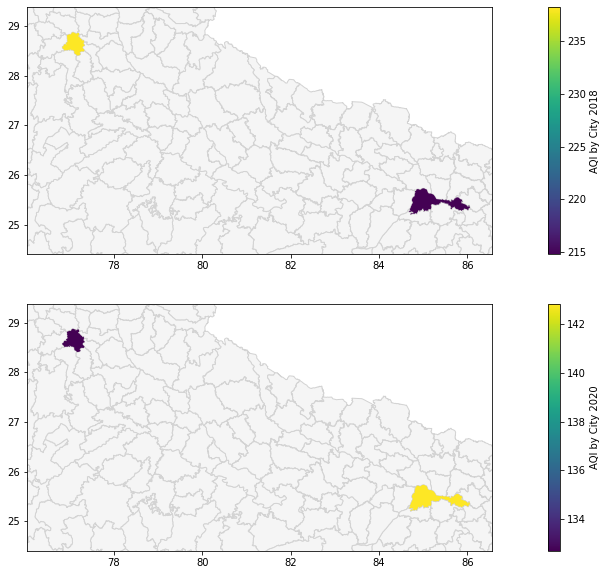

In [ ]:
# Plot the AQI on map for differnt years
fig, ax = plt.subplots(2,1, figsize=(20, 10))

gdf_india.plot(column = 'NAME_0',
                    color = 'whitesmoke',
                    edgecolor = 'lightgrey',
                    ax=ax[0])
    
gdf.plot(column = 'AQI_2018',
                    legend = True,
                    ax=ax[0],
                    legend_kwds = {'label': "AQI by City 2018"})

minx, miny, maxx, maxy = gdf.total_bounds
ax[0].set_xlim(minx - 0.8, maxx+0.5)
ax[0].set_ylim(miny - 0.8, maxy+0.5)


gdf_india.plot(column = 'NAME_0',
                    color = 'whitesmoke',
                    edgecolor = 'lightgrey',
                    ax=ax[1])

gdf.plot(column = 'AQI_2020', 
                    legend = True,
                    ax=ax[1],
                    legend_kwds = {'label': "AQI by City 2020"})

minx, miny, maxx, maxy = gdf.total_bounds
ax[1].set_xlim(minx - 0.8, maxx+0.5)
ax[1].set_ylim(miny - 0.8, maxy+0.5)

From the two plots above, we can see that the 2020 AQI in Patna and Delhi was much lower (around 134 and 142 respectively) as compared to that in 2018, when it was much higher (around 235 and 215 respectively). Thus, the impact of the lockdown can be clearly noted here. Also, if we compare the two cities, we can see that the AQI in Delhi was higher than that of Patna in 2018 but during the lockdown period in 2020, Delhi's AQI fell even below that of Patna.

(24.40235061645502, 29.38451194763195)

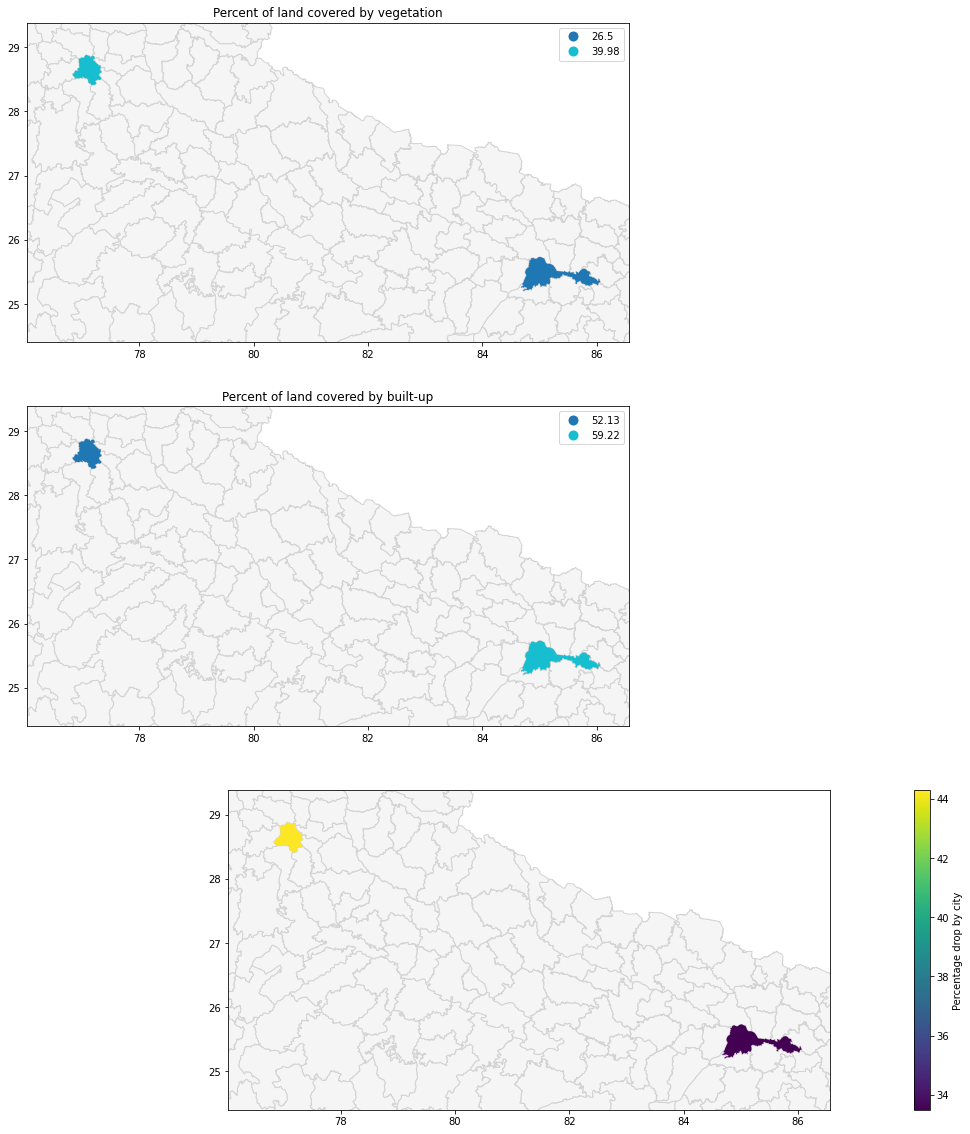

In [ ]:
# Plotting the vegetation, built-up and percentage change in AQI
fig1, axs = plt.subplots(3,1, figsize=(30, 20))
gdf_india.plot(column = 'NAME_0',
                    color = 'whitesmoke',
                    edgecolor = 'lightgrey',
                    ax=axs[2])

gdf.plot(column = 'Percent_dec', 
                    legend = True, 
                    ax=axs[2],
                    legend_kwds = {'label': "Percentage drop by city"})

axs[2].set_xlim(minx - 0.8, maxx+0.5)
axs[2].set_ylim(miny - 0.8, maxy+0.5)


gdf_india.plot(column = 'NAME_0',
                    color = 'whitesmoke',
                    edgecolor = 'lightgrey',
                    ax=axs[0])
gdf.plot(column = 'Per_veg',
                    legend = True, 
                    ax=axs[0])

axs[0].set_title('Percent of land covered by vegetation')
axs[0].set_xlim(minx - 0.8, maxx+0.5)
axs[0].set_ylim(miny - 0.8, maxy+0.5)



gdf_india.plot(column = 'NAME_0',
                    color = 'whitesmoke',
                    edgecolor = 'lightgrey',
                    ax=axs[1])
gdf.plot(column = 'Per_built', 
                    legend = True,
                    ax=axs[1])
axs[1].set_title('Percent of land covered by built-up')
axs[1].set_xlim(minx - 0.8, maxx+0.5)
axs[1].set_ylim(miny - 0.8, maxy+0.5)

**Analysing Other Cities**

In [ ]:
# Checking lockdown and non-lockdown means of AQI and other components of air for other cities
df[(df['Date_year'].isin([2018,2020]))&(df['Date_month'].isin([3,4,5]))].groupby(['City','Date_year']).agg({'AQI':'mean','NO2':'mean','CO':'mean'})

AQI        NO2         CO
City               Date_year                                  
Ahmedabad          2018       555.195652  70.017717  23.142717
                   2020       183.945652  25.457174   3.509022
Aizawl             2020        40.890244   0.450854   0.328780
Amaravati          2018        73.456522  11.761087   0.626196
                   2020        52.097826   6.246413   0.252717
Amritsar           2018       116.173913  12.555652   0.750652
                   2020        73.869565  13.649674   0.722826
Bengaluru          2018        90.402174  29.815217   0.963804
                   2020        77.576087  16.291087   0.816739
Bhopal             2020       101.054348  13.692717   0.517717
Brajrajnagar       2018       179.315217  21.569130   3.638261
                   2020       122.869565  11.854891   0.322065
Chandigarh         2020        58.510870  11.554348   0.523478
Chennai            2018        87.097826  24.294130   0.904565
                   2020        70.902174   8.744674   0.726413
Coimbatore         2020        70.804348  48.317717   0.792174
Delhi              2018       238.250000  48.183043   1.376196
                   2020       132.706522  26.624239   0.857500
Ernakulam          2020        83.597826   1.945000   1.555217
Gurugram           2018       205.250000  32.283804   0.864130
                   2020       126.836957  19.735435   0.814891
Guwahati           2020       124.760870  14.785761   0.509239
Hyderabad          2018       102.760870  38.083804   0.754891
                   2020        74.467391  24.138478   0.475870
Jaipur             2018       150.793478  35.953587   0.841848
                   2020       100.282609  20.074022   0.671522
Jorapokhar         2018       135.956522   8.077935   0.361304
                   2020       133.684783  10.786739   1.442174
Kochi              2020        96.500000   8.455109   1.170000
Kolkata            2018        70.769231  36.428077   0.312692
                   2020        82.250000  15.684783   0.468478
Lucknow            2018       224.793478  46.007065   0.477935
                   2020       120.086957  18.234022   1.014022
Mumbai             2018        77.065217  13.445000   1.455326
                   2020        81.043478  13.089130   0.447609
Patna              2018       214.750000  37.443152   1.298370
                   2020       142.826087  32.413913   0.994891
Shillong           2020        53.771739   2.625109   0.157609
Talcher            2018       184.173913  20.634565   2.056522
                   2020       114.989130  10.371630   1.850543
Thiruvananthapuram 2018        76.163043  11.935435   1.009130
                   2020        62.652174  10.950543   0.678587
Visakhapatnam      2018        90.739130  33.827717   0.577500
                   2020        68.086957  26.666630   0.344565

Let's take a look at the correlation between AQI and various factors, during lockdown and non-lockdown periods.

In [11]:
df[(df['Date_year']==2018)&(df['Date_month'].isin([3,4,5]))].corr()['AQI'].reset_index()

,index,AQI
0,NO2,0.547638
1,NH3,-0.115326
2,CO,0.768404
3,SO2,0.298030
4,Benzene,0.278610
5,AQI,1.000000
6,Date_year,NaN
7,Date_month,-0.155672
8,Week,-0.141609


In [12]:
df[(df['Date_year']==2020)&(df['Date_month'].isin([3,4,5]))].corr()['AQI'].reset_index()

,index,AQI
0,NO2,0.343007
1,NH3,0.043738
2,CO,0.578762
3,SO2,0.382051
4,Benzene,-0.035408
5,AQI,1.000000
6,Date_year,NaN
7,Date_month,-0.167696
8,Week,-0.182192


We can see from the two tables that NO2, CO and SO2 are fairly strongly correlated to AQI as is time. One thing to note here is during the lockdown period NH3 was positively correlated to AQI whereas it was negatively correlated during the non-lockdown period.

Next, using the Chi-square test, let's specifically look at the correlation between AQI and cities for both of these periods separately and see if there are any differences.

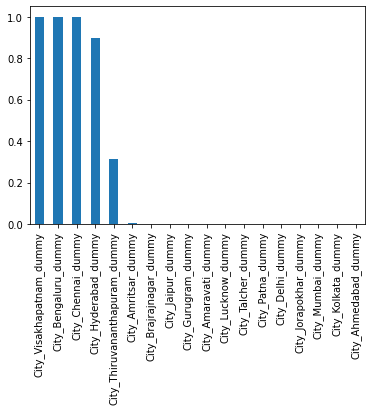

In [55]:
# NON-LOCKDOWN PERIOD
cat_cols = ['City']
corr_col = 'AQI'
X = df[(df['Date_year']==2018)&(df['Date_month'].isin([3,4,5]))][cat_cols]
Y = df[(df['Date_year']==2018)&(df['Date_month'].isin([3,4,5]))][[corr_col]]

for i in cat_cols:
  for a in X[i].unique():
    X[str(i)+'_'+str(a)+'_dummy'] = pd.get_dummies(X[i])[a]

X.drop('City',axis=1,inplace=True)

chi_scores = chi2(X,Y)
chi_scores

p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)
p_df = p_values.reset_index()

p_df[0] = p_df[0].apply(lambda x : round(x, 4))
# p_df
p_values.plot.bar()

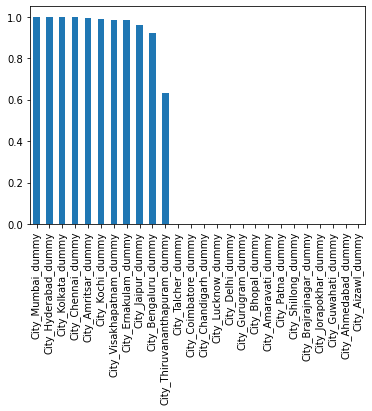

In [56]:
# LOCKDOWN PERIOD
cat_cols = ['City']
corr_col = 'AQI'
X = df[(df['Date_year']==2020)&(df['Date_month'].isin([3,4,5]))][cat_cols]
Y = df[(df['Date_year']==2020)&(df['Date_month'].isin([3,4,5]))][[corr_col]]

for i in cat_cols:
  for a in X[i].unique():
    X[str(i)+'_'+str(a)+'_dummy'] = pd.get_dummies(X[i])[a]

X.drop('City',axis=1,inplace=True)

chi_scores = chi2(X,Y)
chi_scores

p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)
p_df = p_values.reset_index()

p_df[0] = p_df[0].apply(lambda x : round(x, 4))
# p_df
p_values.plot.bar()

For 2018, *Visakhapatnam, Bangalore, Chennai, Hyderabad and Thiruvananthapuram* seem to be very strongly correlated to the AQI, whereas, during 2020, *Mumbai, Hyderabad, Kolkata, Chennai, Amritsar, Kochi, Visakhapatnam, Emakulam, Jaipur, Bangalore and Thiruvananthapuram* are strongly correlated. Thus, as compared to 2018, a lot more cities during the lockdown period have had an impact on air quality and this could be a good indicator that the activities taking place in these cities during lockdown had an effect on the AQI.

Moving forward, I would like to specifically look at some cities.

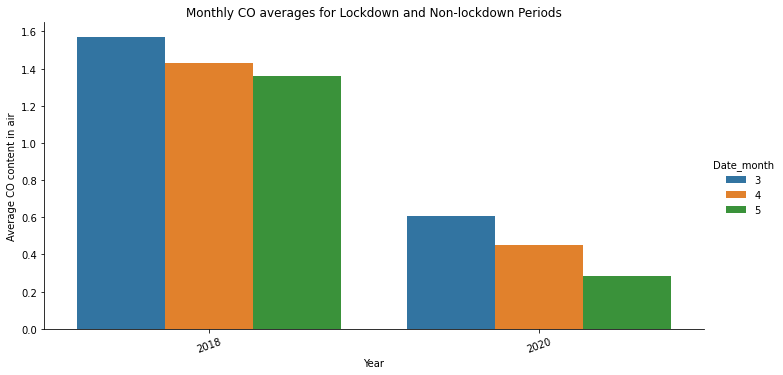

In [ ]:
# Let's look at Mumbai closely
city_filter = (df['City']=='Mumbai')
year_filter = (df['Date_year'].isin([2018,2020]))
month_filter = (df['Date_month'].isin([3,4,5]))
df_1 = df[city_filter & year_filter & month_filter].groupby(['Date_year','Date_month'])['CO'].mean().to_frame().reset_index()
p2 = sns.factorplot('Date_year','CO','Date_month', data=df_1, kind='bar',size=5,aspect = 2)
plt.xticks(rotation=20)
p2.set(title='Monthly CO averages for Lockdown and Non-lockdown Periods',xlabel='Year',ylabel='Average CO content in air')

If we look at the proportions of Carbon Monoxide (CO) specifically, we can see that there is a significant drop in the levels in the months when lockdown was imposed. And not only that, the levels seem to be gradually dropping month on month as well.

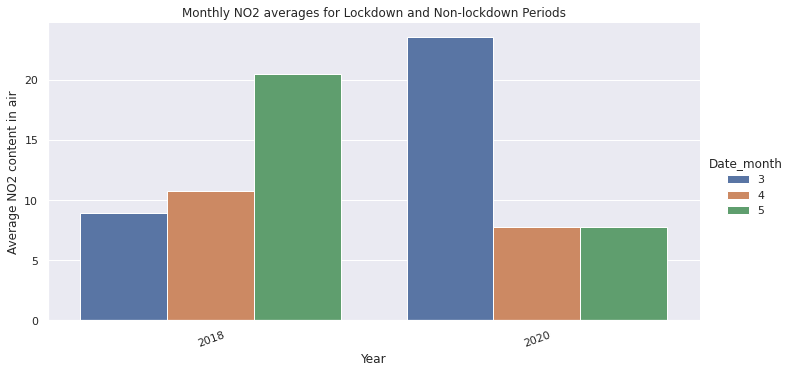

In [ ]:
df_1 = df[city_filter & year_filter & month_filter].groupby(['Date_year','Date_month'])['NO2'].mean().to_frame().reset_index()
p2 = sns.factorplot('Date_year','NO2','Date_month', data=df_1, kind='bar',size=5,aspect = 2)
plt.xticks(rotation=20)
p2.set(title='Mumbai Monthly NO2 averages for Lockdown and Non-lockdown Periods',xlabel='Year',ylabel='Average NO2 content in air')

Though in the case of Nitrogen Dioxide (NO2), the levels actually increased in the first month of lockdown, i.e. March, 2020 as compared to that in March, 2018. But post this, the levels start dropping.

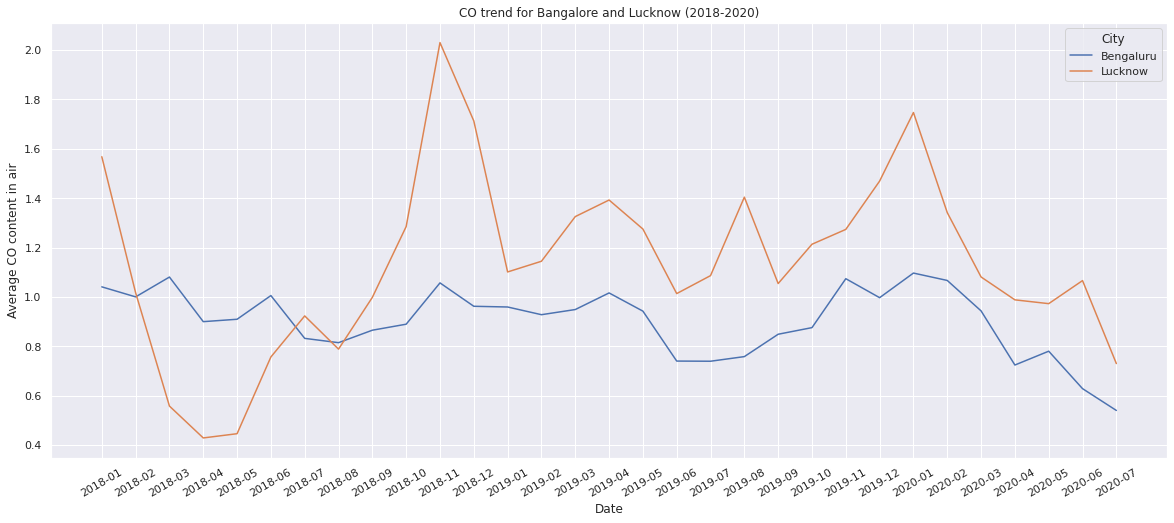

In [ ]:
multiple_city_filter = (df['City'].isin(['Bengaluru','Lucknow']))
date_filter = (df['Date_year'].isin([2018,2019,2020]))
cols_to_select = ['Month','City','CO']
dfp = df[multiple_city_filter & date_filter][cols_to_select].groupby(['City','Month']).agg({'CO':'mean'}).reset_index()
plt.xticks(rotation=30)
p2 = sns.lineplot(x='Month', y='value', hue='City', 
             data=pd.melt(dfp, ['Month','City']))
p2.set(title='CO trend for Bangalore and Lucknow (2018-2020)',xlabel='Date',ylabel='Average CO content in air')
sns.set(rc = {'figure.figsize':(20,8)})


Looking at the week on week averages of CO levels for Bangalore and Lucknow, we can see that though they lie on different scales, there is a consistent gradual pattern from the non-lockdown period to the lockdown period and we can see an evident dip as we enter the weeks of 2020.

In [69]:
metric = 'NO2'
grp_period = 'Week'
city_name = 'Chennai'
cols_to_take = [grp_period,metric]
m1 = df[(df['City']==city_name) & (df['Date_year']==2018) & (df['Date_month'].isin([3,4,5]))][cols_to_take].groupby(grp_period)[metric].mean().to_frame().reset_index()
m1.rename(columns={metric:'2018_'+metric},inplace=True)
m2 = df[(df['City']==city_name) & (df['Date_year']==2020) & (df['Date_month'].isin([3,4,5]))][cols_to_take].groupby(grp_period)[metric].mean().to_frame().reset_index()
m2.rename(columns={metric:'2020_'+metric},inplace=True)

m1 = pd.merge(m1,m2,on=grp_period,how='left')

m1[metric+' percent change'] = ((m1['2020_'+metric]-m1['2018_'+metric])/m1['2018_'+metric])*100.0
m1[metric+' percent change'] = m1[metric+' percent change'].apply(lambda x : round(x,2))
m1['2020_'+metric] = m1['2020_'+metric].apply(lambda x : round(x,2))

In [70]:
# txt_clr = 'white'
txt_clr = 'black'
fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])
# fig = make_subplots(rows=2, cols=2, start_cell="bottom-left",specs=[[{"secondary_y": True}]])
fig.add_trace(
   go.Bar(
       x= m1[grp_period].tolist(),
       y= m1['2020_'+metric].tolist(), width=0.4,
       name=metric+' levels',text=m1['2020_'+metric].unique().tolist(),textposition='outside'
       ,marker_color='#1f77b4',textfont_color=txt_clr),
       secondary_y=True)

fig.add_trace(
    go.Scatter(
        x=m1[grp_period].tolist(),
        y=(m1[metric+' percent change']).tolist(),opacity =0.8,textfont_color="black",
        name='Percent Change',line=dict(width=3),marker_color='#9392f7',textposition='top left'
        ,mode="lines+markers+text",text=m1[metric+' percent change'].unique().tolist()))
# ,secondary_y=False
fig.update_layout(width=850,height=500,plot_bgcolor='rgba(0,0,0,0)',
             font=dict(size=11),
                  legend=go.layout.Legend(x=0.7,y=1.1,traceorder="normal",
                                          font=dict(family="sans-serif",size=11,color="black"),
                                          bgcolor="white",bordercolor="white",
                                          borderwidth=2),margin=go.layout.Margin(t=0,b=10,r=10,l=10,pad=0))
fig.update_layout(title='Weekly '+metric+' averages in 2020 and percent change from 2018')
fig.update_layout(legend_orientation='h',bargap=0.1)
# fig.update_yaxes(secondary_y=False,range=[-100,70])

fig.update_yaxes(title='Percent Change',secondary_y=False,range=[-260,70])
fig.update_yaxes(title=metric+' levels',secondary_y=True,range=[0,20])
fig.update_xaxes(title='Week Number')

# fig.update_yaxes(secondary_y=False,range=[-70,170])
# fig.update_yaxes(secondary_y=True,range=[0,150])
# fig.update_yaxes(secondary_y=True,range=[0,2])
fig.show()

In terms of weekly averages of Nitrogen Dioxide (NO2) levels during the lockdown months, the patterns are inconsistent as some weeks record higher levels than others and so there are dips as well as peaks but when comparing these levels to those in 2018, there has been a percentage decrease at every week.

From https://tn.data.gov.in/node/6881706#web_catalog_tabs_block_10 , I found the year on year number of operating factories in Chennai.

In [59]:
# Reading the factories dataset
worksheet = gc.open('No of factories in TN.csv').sheet1
rows = worksheet.get_all_values()
f_df = pd.DataFrame.from_records(rows)
f_df.columns = f_df.loc[0].tolist()
f_df.drop(index=0,inplace=True)
f_df.reset_index(drop=True,inplace=True)

In [67]:
metric = 'NH3'
grp_period = 'Date_year'
city_name = 'Chennai'
cols_to_take = [grp_period,metric]
m1 = df[(df['City']==city_name) & (df['Date_year']==2018)][cols_to_take].groupby(grp_period)[metric].mean().to_frame().reset_index()
m1['No of operating factories'] = int(f_df[f_df['Year']=='2018']['Number of Factories'].values[0])
m2 = df[(df['City']==city_name) & (df['Date_year']==2020)][cols_to_take].groupby(grp_period)[metric].mean().to_frame().reset_index()
m2['No of operating factories'] = int(f_df[f_df['Year']=='2020']['Number of Factories'].values[0])

m2[metric] = m2[metric].apply(lambda x : round(x,2))
m2 = m2.append(m1)

m2['No of operating factories'] = m2['No of operating factories']/1000
m2['No of operating factories'] = m2['No of operating factories'].apply(lambda x : round(x,2))
m2[metric] = m2[metric].apply(lambda x : round(x,2))

In [68]:
# # txt_clr = 'white'
txt_clr = 'black'
fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
   go.Bar(
       x= m2['Date_year'].tolist(),
       y= m2[metric].unique().tolist(),
       name=metric,text=m2[metric].unique().tolist(),textposition='outside'
       ,marker_color='#1f77b4',textfont_color=txt_clr,offsetgroup=1))

fig.add_trace(
   go.Bar(
       x= m2['Date_year'].tolist(),
       y= m2['No of operating factories'].unique().tolist(),
       name="No of operating factories",text=m2['No of operating factories'].unique().tolist(),textposition='outside'
       ,textfont_color=txt_clr,offsetgroup=2))

fig.update_layout(title='Yearly '+metric+' averages vs total no of operating factories (in thousands)')
fig.update_layout(width=600,
                  height=550,plot_bgcolor='rgba(0,0,0,0)',font=dict(size=11),
    legend=go.layout.Legend(x=0.7,y=1.1,traceorder="normal",
                                          font=dict(family="sans-serif",size=11,color="black"),
                                          bgcolor="white",bordercolor="white",
                                          borderwidth=2),margin=go.layout.Margin(t=170,b=10,r=10,l=10,pad=0)
)

fig.update_layout(legend_orientation='h')
fig.update_yaxes(title_text="NH3 levels/No of operating factories", secondary_y=False,range=[5,50])
fig.update_xaxes(title='Year')
fig.show()

If we compare the average Ammonia (NH3) levels as well as the number of operating factories during the two periods, we can see that the levels decrease during lockdown and to add to this, a lower number of factories also seem to be in effect. Thus, there is possibly a correlation between AQI and the number of operating factories.

**Conclusion :**  All in all, there seems to be sufficient evidence that there has been improvement in air quality during the lockdown. Similarly, we can say that increased vegetative cover or decreased built up land can also result in improved air quality. 